# Processing data from Ding2018.PRA.98.042505

Spectroscopy of 87Sr triplet Rydberg states
R. Ding, J. D. Whalen, S. K. Kanungo, T. C. Killian, F. B. Dunning, S. Yoshida, and J. Burgdörfer
Phys. Rev. A 98, 042505 (2018)
https://doi.org/10.1103/PhysRevA.98.042505

In [172]:
import os
import glob

import pandas as pd
import numpy as np
from uncertainties import ufloat, unumpy

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

from lmfit.models import Model

# conda install -c astropy emcee 
import emcee

## Constants
Constants to be set for each particular data set.

In [173]:
# Constants that should not need changing
C = 299792458 # Speed of light in [m/s]

# CODATA 2014 constants
RY_inf = ufloat(10973731.568508, 0.000065)/100 # Rydberg constant [/cm]
AMU = ufloat(1.660539040, 0.000000020)*1E-27 # Atomic mass unit [kg]
M_E = ufloat(9.10938356, 0.00000011)*1E-31 # Electron mass [kg]

M_88 = ufloat(87905612.256, 0.006)*1E-6*AMU
M_87 = ufloat(86908877.496, 0.005)*1E-6*AMU
M_86 = ufloat(85909260.726, 0.006)*1E-6*AMU
M_84 = ufloat(83913419.1, 1.3)*1E-6*AMU

out = pd.DataFrame(columns=['Series','n', 'Term', 'Label', 'E_exp', 'E_exp_unc', 'Isotope', 'Reference'])

In [174]:
# Constants which should change depending on the data set being analyzed
REFERENCE = 'Ding2018.PRA.98.042505'
PATH_TO_RAW_DATA = os.path.join('source','Ding2018.PRA.98.042505*.csv')
OUTPUT_FILE_NAME = REFERENCE + '-analyzed.csv'

ISOTOPE = 87

#I_S = ufloat(1377012721, 10)/(C*100/1E6) # Given ionization limit for 88Sr in paper.
#I_S = ufloat(45932.1956, 0) # Given ionization limit for 87Sr in paper.

#RY_Sr = 109736.631 # Rydberg constant in [/cm]
RY_Sr = RY_inf*(M_87/(M_E + M_87))

## Read in all the files to a single DataFrame

In [175]:
# Goes through all listed .csv files and returns data in a single DataFrame

source_list = glob.glob(PATH_TO_RAW_DATA)

def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        
        out = pd.concat([out, df], join='outer', ignore_index=True, sort=False)
    
    return out

data = gather_data(source_list)

## Process data
May need to tweak depending on the data set being analyzed.

### Adding in uncertainty

In [176]:
# Uncertainty is given in the paper for each measurement

### Fitting to obtain quantum defects

#### 5sns, 1S0 and 3S1 states

In [179]:
# Calculating Rydberg energy based on I_s (ionization limit) and quantum defects (d0, d2, d4)
def rydberg_energy(n, I_S, delta):
    
    [d0, d2, d4] = delta
    
    qd = d0 + d2/(n-d0)**2 + d4/(n-d0)**4
    R = RY_Sr.nominal_value
    
    return I_S - R/(n-qd)**2

def hyperfine_shift_S(n, Term, F, I_S, d1S0_0, d1S0_2, d1S0_4, d3S1_0, d3S1_2, d3S1_4):
    
    i = 9/2 # 87Sr nuclear spin
    
    # 87Sr+ hyperfine interaction constant [kHz] from Sunaoshi et. al., Hyperfine Interact. 78, 241 (1993).
    a_5s = ufloat(-1000473.673, 0.011)
    a_5s = a_5s.nominal_value/(C*100/1E3) # 87Sr+ hyperfine interaction constant [/cm]
    
    x = np.hstack((np.array([n]).T, np.array([Term]).T, np.array([F]).T))
    shift = np.zeros(len(n))
    
    for j in range(len(x)):
        
        E_1S0 = rydberg_energy(x[j, 0], I_S, [d1S0_0, d1S0_2, d1S0_4])
        E_3S1 = rydberg_energy(x[j, 0], I_S, [d3S1_0, d3S1_2, d3S1_4])
        
        if x[j, 2] == 11/2:
            shift[j] = 1/2*a_5s*i + E_3S1
            
            
        elif x[j, 2] == 7/2:
            shift[j] = -1/2*a_5s*(i+1)  + E_3S1
            
        elif x[j, 2] == 9/2:
            
            if x[j, 1] == '1S0':
                shift[j] = (1/4)*(2*(E_1S0+E_3S1)-a_5s+np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0-E_3S1)+a_5s**2*(2*i+1)**2))
                #shift[i] = shift[i]-E_1S0

            elif x[j, 1] == '3S1':
                shift[j] = (1/4)*(2*(E_1S0+E_3S1)-a_5s-np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0-E_3S1)+a_5s**2*(2*i+1)**2))
                #shift[i] = shift[i] - E_3S1
                
            else:
                print('Error')
        else:
            print('Error')
            
    return shift

data_to_fit = data[data['Series']=='5sns']

# Fitting
fit_model = Model(hyperfine_shift_S, independent_vars=['n', 'Term', 'F'])
fit_params = fit_model.make_params()

fit_params['I_S'].set(45932.1956, min=0, vary=True)
fit_params['d1S0_0'].set(3.26896, vary=True)
fit_params['d1S0_2'].set(-0.138, vary=True)
fit_params['d1S0_4'].set(0.9, vary=True)
fit_params['d3S1_0'].set(3.37065, vary=True)
fit_params['d3S1_2'].set(0.443, vary=True)
fit_params['d3S1_4'].set(-0.553, vary=True)

# Initial guess
#xfit = np.linspace(min(n), max(n), num=1000, endpoint=True)
#yinit = fit_model.eval(fit_params, n=n, term=term, F=F)
fit_kws = {'xtol':1E-25,
           'ftol':1E-25,
           'maxfev':20000*(10+1)}
fit_result = fit_model.fit(data_to_fit['E_expt'], fit_params, n=data_to_fit['n'], Term=data_to_fit['Term'], F=data_to_fit['F'],
                           method='least_squares')

#dely = fit_result.eval_uncertainty(n=data_to_fit['n'], Term=data_to_fit['Term'], F=data_to_fit['F'])
#yfit = fit_model.eval(fit_result.params, n=data_to_fit['n'], Term=data_to_fit['Term'], F=data_to_fit['F'])

print(fit_result.fit_report())

[[Model]]
    Model(hyperfine_shift_S)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 60
    # variables        = 7
    chi-square         = 7.2090e-05
    reduced chi-square = 1.3602e-06
    Akaike info crit   = -803.916038
    Bayesian info crit = -789.255626
[[Variables]]
    I_S:     45932.1962 (init = 45932.2)
    d1S0_0:  3.27191787 (init = 3.26896)
    d1S0_2: -5.24006749 (init = -0.138)
    d1S0_4:  1144.73066 (init = 0.9)
    d3S1_0:  3.37071129 (init = 3.37065)
    d3S1_2:  0.41049157 (init = 0.443)
    d3S1_4: -0.55300000 (init = -0.553)



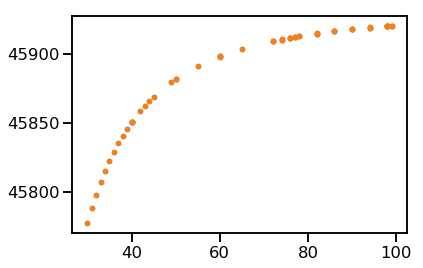

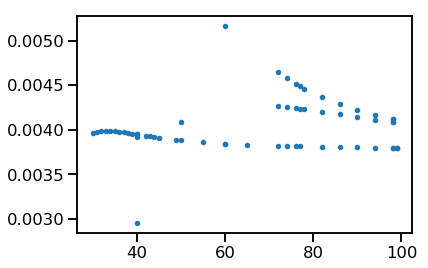

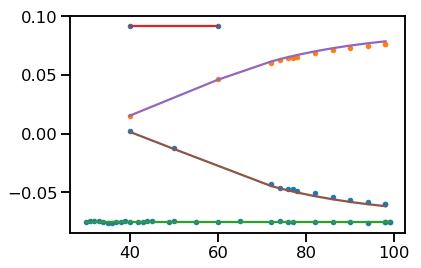

In [180]:
x = np.linspace(20, 100, 1000)
E_1S0 = rydberg_energy(x, 45932.2, [3.26896, -0.138, 0.9])
E_3S1 = rydberg_energy(x, 45932.2, [3.37065, 0.443, -0.553])

i=9/2
a_5s = ufloat(-1000473.673, 0.011)
a_5s = a_5s.nominal_value/(C*100/1E3) # 87Sr+ hyperfine interaction constant [/cm]
shift_1S0 = (1/4)*(2*(E_1S0+E_3S1)-a_5s+np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0-E_3S1)+a_5s**2*(2*i+1)**2)) - E_1S0
shift_3S1 = (1/4)*(2*(E_1S0+E_3S1)-a_5s-np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0-E_3S1)+a_5s**2*(2*i+1)**2)) - E_3S1

n=data_to_fit['n']
Term=data_to_fit['Term']
F=data_to_fit['F']
x = np.hstack((np.array([n]).T, np.array([Term]).T, np.array([F]).T))

plt.figure()
plt.plot(x[:,0], hyperfine_shift_S(x[:,0], x[:,1], x[:,2], 45932.2, 3.26896, -0.138, 0.9, 3.37065, 0.443, -0.553) , '.')
plt.plot(x[:,0], hyperfine_shift_S(x[:,0], x[:,1], x[:,2], fit_result.params['I_S'],
                                   fit_result.params['d1S0_0'].value, 
                                   fit_result.params['d1S0_2'].value, 
                                   fit_result.params['d1S0_4'].value, 
                                   fit_result.params['d3S1_0'].value, 
                                   fit_result.params['d3S1_2'].value, 
                                   fit_result.params['d3S1_4'].value) , '.')
plt.show()

plt.figure()
plt.plot(x[:,0], hyperfine_shift_S(x[:,0], x[:,1], x[:,2], 45932.2, 3.26896, -0.138, 0.9, 3.37065, 0.443, -0.553)-hyperfine_shift_S(x[:,0], x[:,1], x[:,2], fit_result.params['I_S'],
                                   fit_result.params['d1S0_0'].value, 
                                   fit_result.params['d1S0_2'].value, 
                                   fit_result.params['d1S0_4'].value, 
                                   fit_result.params['d3S1_0'].value, 
                                   fit_result.params['d3S1_2'].value, 
                                   fit_result.params['d3S1_4'].value) , '.')
plt.show()

plt.figure()
# Data
n=data_to_fit[data_to_fit['Term']=='3S1']['n']
Term=data_to_fit[data_to_fit['Term']=='3S1']['Term']
F=data_to_fit[data_to_fit['Term']=='3S1']['F']
energy=data_to_fit[data_to_fit['Term']=='3S1']['E_expt']
x = np.hstack((np.array([n]).T, np.array([Term]).T, np.array([F]).T))
delta = [fit_result.params['d3S1_0'].value, fit_result.params['d3S1_2'].value, fit_result.params['d3S1_4'].value]
shift = energy - rydberg_energy(n, fit_result.params['I_S'], delta) 
plt.plot(n, shift, '.')

n=data_to_fit[data_to_fit['Term']=='1S0']['n']
Term=data_to_fit[data_to_fit['Term']=='1S0']['Term']
F=data_to_fit[data_to_fit['Term']=='1S0']['F']
energy=data_to_fit[data_to_fit['Term']=='1S0']['E_expt']
x = np.hstack((np.array([n]).T, np.array([Term]).T, np.array([F]).T))
delta = [fit_result.params['d1S0_0'].value, fit_result.params['d1S0_2'].value, fit_result.params['d1S0_4'].value]
shift = energy - rydberg_energy(n, fit_result.params['I_S'], delta) 
plt.plot(n, shift, '.')

# F=11/2
n=data_to_fit[data_to_fit['F']==11/2]['n']
Term=data_to_fit[data_to_fit['F']==11/2]['Term']
F=data_to_fit[data_to_fit['F']==11/2]['F']
x = np.hstack((np.array([n]).T, np.array([Term]).T, np.array([F]).T))
delta = [fit_result.params['d3S1_0'].value, fit_result.params['d3S1_2'].value, fit_result.params['d3S1_4'].value]
shift = hyperfine_shift_S(x[:,0], x[:,1], x[:,2], 
                          fit_result.params['I_S'],
                          fit_result.params['d1S0_0'].value, 
                          fit_result.params['d1S0_2'].value, 
                          fit_result.params['d1S0_4'].value, 
                          fit_result.params['d3S1_0'].value, 
                          fit_result.params['d3S1_2'].value, 
                          fit_result.params['d3S1_4'].value)
shift = shift - rydberg_energy(n, fit_result.params['I_S'], delta)
plt.plot(n, shift)

# F=11/2
n=data_to_fit[data_to_fit['F']==7/2]['n']
Term=data_to_fit[data_to_fit['F']==7/2]['Term']
F=data_to_fit[data_to_fit['F']==7/2]['F']
x = np.hstack((np.array([n]).T, np.array([Term]).T, np.array([F]).T))
delta = [fit_result.params['d3S1_0'].value, fit_result.params['d3S1_2'].value, fit_result.params['d3S1_4'].value]
shift = hyperfine_shift_S(x[:,0], x[:,1], x[:,2], 
                          fit_result.params['I_S'],
                          fit_result.params['d1S0_0'].value, 
                          fit_result.params['d1S0_2'].value, 
                          fit_result.params['d1S0_4'].value, 
                          fit_result.params['d3S1_0'].value, 
                          fit_result.params['d3S1_2'].value, 
                          fit_result.params['d3S1_4'].value)
shift = shift - rydberg_energy(n, fit_result.params['I_S'], delta)
plt.plot(n, shift)

# F=9/2, 1S0
n=data_to_fit[(data_to_fit['F']==9/2) & (data_to_fit['Term']=='1S0')]['n']
Term=data_to_fit[(data_to_fit['F']==9/2) & (data_to_fit['Term']=='1S0')]['Term']
F=data_to_fit[(data_to_fit['F']==9/2) & (data_to_fit['Term']=='1S0')]['F']
x = np.hstack((np.array([n]).T, np.array([Term]).T, np.array([F]).T))
delta = [fit_result.params['d1S0_0'].value, fit_result.params['d1S0_2'].value, fit_result.params['d1S0_4'].value]
shift = hyperfine_shift_S(x[:,0], x[:,1], x[:,2], 
                          fit_result.params['I_S'],
                          fit_result.params['d1S0_0'].value, 
                          fit_result.params['d1S0_2'].value, 
                          fit_result.params['d1S0_4'].value, 
                          fit_result.params['d3S1_0'].value, 
                          fit_result.params['d3S1_2'].value, 
                          fit_result.params['d3S1_4'].value)
shift = shift - rydberg_energy(n, fit_result.params['I_S'], delta)
plt.plot(n, shift)

# F=9/2, 3S1
n=data_to_fit[(data_to_fit['F']==9/2) & (data_to_fit['Term']=='3S1')]['n']
Term=data_to_fit[(data_to_fit['F']==9/2) & (data_to_fit['Term']=='3S1')]['Term']
F=data_to_fit[(data_to_fit['F']==9/2) & (data_to_fit['Term']=='3S1')]['F']
x = np.hstack((np.array([n]).T, np.array([Term]).T, np.array([F]).T))
delta = [fit_result.params['d3S1_0'].value, fit_result.params['d3S1_2'].value, fit_result.params['d3S1_4'].value]
shift = hyperfine_shift_S(x[:,0], x[:,1], x[:,2], 
                          fit_result.params['I_S'],
                          fit_result.params['d1S0_0'].value, 
                          fit_result.params['d1S0_2'].value, 
                          fit_result.params['d1S0_4'].value, 
                          fit_result.params['d3S1_0'].value, 
                          fit_result.params['d3S1_2'].value, 
                          fit_result.params['d3S1_4'].value)
shift = shift - rydberg_energy(n, fit_result.params['I_S'], delta)

plt.plot(n, shift)
plt.show()

In [131]:
shift

array([45777.36369245, 45788.36407357, 45798.23189123, 45807.11745307,
       45815.14693337, 45822.42687804, 45829.04775818, 45835.08679502,
       45840.6102222 , 45845.6751099 , 45850.33084515, 45858.58102635,
       45862.24567076, 45865.64305906, 45868.79856107, 45879.41415645,
       45881.6506186 , 45890.95288708, 45897.90175574, 45903.22898116,
       45908.82224038, 45910.12305846, 45911.31790039, 45911.87914151,
       45914.37163809, 45916.04850463, 45917.49849578, 45918.7607669 ,
       45919.86637681, 45920.12133154, 45919.86637681, 45920.12133154])

In [ ]:
# 2019/04/18 - almost working....

# Calculating Rydberg energy based on I_s (ionization limit) and quantum defects (d0, d2, d4)
def rydberg_energy(n, I_S, delta):
    
    [d0, d2, d4] = delta
    
    qd = d0 + d2/(n-d0)**2 + d4/(n-d0)**4
    R = RY_Sr.nominal_value
    
    return I_S - R/(n-qd)**2

def hyperfine_shift_S(n, Term, F, I_S, d1S0_0, d1S0_2, d1S0_4, d3S1_0, d3S1_2, d3S1_4):
    
    i = 9/2 # 87Sr nuclear spin
    
    # 87Sr+ hyperfine interaction constant [kHz] from Sunaoshi et. al., Hyperfine Interact. 78, 241 (1993).
    a_5s = ufloat(-1000473.673, 0.011)
    a_5s = a_5s.nominal_value/(C*100/1E3) # 87Sr+ hyperfine interaction constant [/cm]
    
    shift = pd.Series(np.zeros(len(n)))
    
    # Shift of 5sns, 3S1, F=11/2 states
    idx = F.index[F==11/2].tolist()
    shift.iloc[idx] = 1/2*a_5s*i
    
    # Shift of 5sns, 3S1, F=7/2 states
    idx = F.index[F==7/2].tolist()
    shift.iloc[idx] = -1/2*a_5s*(i+1)
    
    # Shift of 5sns, 1S0, F=9/2 states
    idx = (F.index[F==9/2] & Term.index[Term=='1S0']).tolist()
    E_1S0 = np.array(rydberg_energy(n.iloc[idx], I_S, [d1S0_0, d1S0_2, d1S0_4]))
    E_3S1 = np.array(rydberg_energy(n.iloc[idx], I_S, [d3S1_0, d3S1_2, d3S1_4]))
    
    shift.iloc[idx] = (1/4)*(2*(E_1S0+E_3S1)-a_5s+np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0 - E_3S1)+a_5s**2*(2*i+1)**2))
    shift.iloc[idx] = shift.iloc[idx] - E_1S0
    
    # Shift of 5sns, 3S1, F=9/2 states
    idx = (F.index[F==9/2] & Term.index[Term=='3S1']).tolist()
    E_1S0 = np.array(rydberg_energy(n.iloc[idx], I_S, [d1S0_0, d1S0_2, d1S0_4]))
    E_3S1 = np.array(rydberg_energy(n.iloc[idx], I_S, [d3S1_0, d3S1_2, d3S1_4]))
    shift.iloc[idx] = E_3S1
    
    shift.iloc[idx] = (1/4)*(2*(E_1S0+E_3S1)-a_5s-np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0-E_3S1)+a_5s**2*(2*i+1)**2))
    shift.iloc[idx] = shift.iloc[idx] - E_3S1
    
    print(shift)
    
    return np.array(shift)

# Making x = [[n], [term], [F]]
n = data['n']
Term = data['Term']
F = data['F']
ydata = data['E_expt']
ydata_unc = data['E_expt_unc']

# Fitting
fit_model = Model(hyperfine_shift_S, independent_vars=['n', 'Term', 'F'])
fit_params = fit_model.make_params()

fit_params['I_S'].set(45932.1956, vary=True)
fit_params['d1S0_0'].set(3.26896, vary=True)
fit_params['d1S0_2'].set(-0.138, vary=True)
fit_params['d1S0_4'].set(0.9, vary=True)
fit_params['d3S1_0'].set(3.37065, vary=True)
fit_params['d3S1_2'].set(0.443, vary=True)
fit_params['d3S1_4'].set(-0.553, vary=True)

# Initial guess
#xfit = np.linspace(min(n), max(n), num=1000, endpoint=True)
#yinit = fit_model.eval(fit_params, n=n, term=term, F=F)
fit_result = fit_model.fit(data['E_expt'], n=data['n'], Term=data['Term'], F=data['F'])

print(fit_result.fit_report())

In [390]:
# 2019/04/18 - almost working....

# Calculating Rydberg energy based on I_s (ionization limit) and quantum defects (d0, d2, d4)
def rydberg_energy(n, I_S, delta):
    
    [d0, d2, d4] = delta
    
    qd = d0 + d2/(n-d0)**2 + d4/(n-d0)**4
    R = RY_Sr.nominal_value
    
    return I_S - R/(n-qd)**2

def hyperfine_shift_S(n, Term, F, I_S, d1S0_0, d1S0_2, d1S0_4, d3S1_0, d3S1_2, d3S1_4):
    
    i = 9/2 # 87Sr nuclear spin
    
    # 87Sr+ hyperfine interaction constant [kHz] from Sunaoshi et. al., Hyperfine Interact. 78, 241 (1993).
    a_5s = ufloat(-1000473.673, 0.011)
    a_5s = a_5s.nominal_value/(C*100/1E3) # 87Sr+ hyperfine interaction constant [/cm]
    
    shift = pd.Series(np.zeros(len(n)))
    
    # Shift of 5sns, 3S1, F=11/2 states
    idx = F.index[F==11/2].tolist()
    shift.iloc[idx] = 1/2*a_5s*i
    
    # Shift of 5sns, 3S1, F=7/2 states
    idx = F.index[F==7/2].tolist()
    shift.iloc[idx] = -1/2*a_5s*(i+1)
    
    # Shift of 5sns, 1S0, F=9/2 states
    idx = (F.index[F==9/2] & Term.index[Term=='1S0']).tolist()
    E_1S0 = np.array(rydberg_energy(n.iloc[idx], I_S, [d1S0_0, d1S0_2, d1S0_4]))
    E_3S1 = np.array(rydberg_energy(n.iloc[idx], I_S, [d3S1_0, d3S1_2, d3S1_4]))
    
    shift.iloc[idx] = (1/4)*(2*(E_1S0+E_3S1)-a_5s+np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0 - E_3S1)+a_5s**2*(2*i+1)**2))
    shift.iloc[idx] = shift.iloc[idx] - E_1S0
    
    # Shift of 5sns, 3S1, F=9/2 states
    idx = (F.index[F==9/2] & Term.index[Term=='3S1']).tolist()
    E_1S0 = np.array(rydberg_energy(n.iloc[idx], I_S, [d1S0_0, d1S0_2, d1S0_4]))
    E_3S1 = np.array(rydberg_energy(n.iloc[idx], I_S, [d3S1_0, d3S1_2, d3S1_4]))
    shift.iloc[idx] = E_3S1
    
    shift.iloc[idx] = (1/4)*(2*(E_1S0+E_3S1)-a_5s-np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0-E_3S1)+a_5s**2*(2*i+1)**2))
    shift.iloc[idx] = shift.iloc[idx] - E_3S1
    
    return np.array(shift)

# Making x = [[n], [term], [F]]
n = data['n']
Term = data['Term']
F = data['F']
ydata = data['E_expt']
ydata_unc = data['E_expt_unc']

# Fitting
fit_model = Model(hyperfine_shift_S, independent_vars=['n', 'Term', 'F'])
fit_params = fit_model.make_params()

fit_params['I_S'].set(45932.1956, min=0, vary=True)
fit_params['d1S0_0'].set(3.26896, vary=True)
fit_params['d1S0_2'].set(-0.138, vary=True)
fit_params['d1S0_4'].set(0.9, vary=True)
fit_params['d3S1_0'].set(3.37065, vary=True)
fit_params['d3S1_2'].set(0.443, vary=True)
fit_params['d3S1_4'].set(-0.553, vary=True)

# Initial guess
#xfit = np.linspace(min(n), max(n), num=1000, endpoint=True)
#yinit = fit_model.eval(fit_params, n=n, term=term, F=F)
fit_result = fit_model.fit(data['E_expt'], fit_params, n=data['n'], Term=data['Term'], F=data['F'])

print(fit_result.fit_report())

[[Model]]
    Model(hyperfine_shift_S)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 89
    # variables        = 7
    chi-square         = 1.8744e+11
    reduced chi-square = 2.2859e+09
    Akaike info crit   = 1924.66175
    Bayesian info crit = 1942.08220
[[Variables]]
    I_S:     7377223.51 (init = 45932.2)
    d1S0_0:  3.51233181 (init = 3.26896)
    d1S0_2: -66.6597885 (init = -0.138)
    d1S0_4:  0.90000000 (init = 0.9)
    d3S1_0:  3.36170469 (init = 3.37065)
    d3S1_2:  215.083136 (init = 0.443)
    d3S1_4: -0.55300000 (init = -0.553)



In [233]:
n = np.linspace(min)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 81]

In [234]:
data.head()

,Series,n,Term,F,E_expt,E_expt_unc,DeltaE_Expt,DeltaE_Expt_unc,E_theor,DeltaE_theor,New
0,5sns,40,1S0,4.5,45850.8762,0.0021,16.35,0.08,45850.8702,16.22,True
1,5sns,60,1S0,4.5,45898.1444,0.0022,7.28,0.09,45898.1421,7.26,True
2,5sns,72,1S0,4.5,45909.0252,0.0020,6.10,0.09,45909.0240,6.10,True
3,5sns,74,1S0,4.5,45910.3230,0.0021,5.98,0.09,45910.3211,5.99,True
4,5sns,76,1S0,4.5,45911.5148,0.0020,5.91,0.08,45911.5127,5.89,True


In [286]:
# Calculating Rydberg energy based on I_s (ionization limit) and quantum defects (d0, d2, d4)
def rydberg_energy(n, I_S, delta):
    
    [d0, d2, d4] = delta
    
    qd = d0 + d2/(n-d0)**2 + d4/(n-d0)**4
    R = RY_Sr.nominal_value
    
    return I_S - R/(n-qd)**2

def hyperfine_shift_S(x, I_S, delta_1S0, delta_3S1):
    [n, term, F] = x
    i = 9/2 # 87Sr nuclear spin
    
    # 87Sr+ hyperfine interaction constant [kHz] from Sunaoshi et. al., Hyperfine Interact. 78, 241 (1993).
    a_5s = ufloat(-1000473.673, 0.011)
    a_5s = a_5s/(C*100/1E3) # 87Sr+ hyperfine interaction constant [/cm]
    
    shift = 0
    
    if F == 11/2:
        shift = 1/2*a_5s*i
        
    elif F == 7/2:
        shift = -1/2*a_5s*(i+1)
        
    elif F == 9/2:
        E_1S0 = rydberg_energy(n, d1S0_0, d1S0_2, d1S0_4)
        E_3S1 = rydberg_energy(n, d3S1_0, d3S1_2, d3S1_4)
        
        if term == '1S0':
            shift = (1/4)*(2*(E_1S0+E_3S1)-a_5s+np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0 - E_3S1)+a_5s**2*(2*i+1)**2))
            shift = shift - E_1S0
        
        elif term == '3S1':
            shift = (1/4)*(2*(E_1S0+E_3S1)-a_5s-np.sqrt(4*(E_1S0-E_3S1)**2+4*a_5s*(E_1S0-E_3S1)+a_5s**2*(2*i+1)**2))
            shift = shift - E_3S1
        
        else:
            print('Error')
    
    else:
        print('Error')
    
    return shift

# Fitting

n = data['n']
term = data['Term']
F = data['F']

x = np.vstack((n, term, F))

fit_model = Model(hyperfine_shift_S, independent_vars=('x'))
fit_params = fit_model.make_params()

fit_params['d1S0_0'].set(3.26896, vary=True)
fit_params['d1S0_2'].set(-0.138, vary=True)
fit_params['d1S0_4'].set(0.9, vary=True)

fit_params['d3S1_0'].set(3.371, vary=True)
fit_params['d3S1_2'].set(0.5, vary=True)
fit_params['d3S1_4'].set(-10, vary=True)

# Initial guess
xfit = np.linspace(min(n), max(n), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=x)

KeyError: 'd1S0_0'

In [63]:
# lmfits outline
data = pol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -30
xmax = -22

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = PseudoVoigtModel(prefix='d0_')

fit_model = bg + d0
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(-25.3, vary=True)
fit_params['d0_amplitude'].set(1768, min=0, vary=True)
fit_params['d0_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=10)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

NameError: name 'pol_data' is not defined

In [285]:
RY_Sr.nominal_value

109736.62301353207

### Calculating state energies after removing hyperfine shift

In [6]:
# Calculating the hyperfine shift of the 5sns S-states
def hyperfine_shift_S(n, term, F):
    
    i = 9/2 # 87Sr nuclear spin
    
    # 87Sr+ hyperfine interaction constant [kHz] from Sunaoshi et. al., Hyperfine Interact. 78, 241 (1993).
    a_5s = ufloat(-1000473.673, 0.011)
    
    a_5s = a_5s/(C*100/1E3) # 87Sr+ hyperfine interaction constant [/cm]
    
    shift = 0
    if F == 11/2:
        shift = 1/2*a_5s*i
        
    elif F == 7/2:
        shift = -1/2*a_5s*(i+1)
        
    elif F == 9/2:
        if term == '1S0':
            shift = 0
        
        elif term == '3S1':
            shift = 0
        
        else:
            print('Error')
    
    else:
        print('Error')
    
    return shift

def hyperfine_shift_D(n, term, F):
    return 0

data['E_expt_noHF'] = data['E_expt']
data['E_expt_noHF_unc'] = data['E_expt_unc']

# Simple first pass
for idx, row in data.iterrows():
    n = row['n']
    series = row['Series']
    term = row['Term']
    F = row['F']
    
    if (series == '5sns') and (term == '1S0' or term == '3S1'):
        HF_shift = hyperfine_shift_S(n, term, F)
        
        data.at[idx, 'E_expt_noHF'] = row['E_expt_noHF'] - HF_shift.nominal_value
        data.at[idx, 'E_expt_noHF_unc'] = row['E_expt_noHF_unc'] - HF_shift.std_dev
    
    elif (series == '5snd') and (term == '1D2' or term == '3D1' or term == '3D2' or term == '3D3'):
        pass
    
    else:
        print('Error')

# Temporary code : remove F=9/2 data points
data = data[~(data['F']==9/2)]

AttributeError: 'int' object has no attribute 'nominal_value'

### Doing any additional filtering (e.g., excluding some ranges, etc.)

In [ ]:
# Only keep data that's newly presented (some data tables include previously measured data)
data_working = data[data['New'] & ~pd.isna(data['New'])]

### Put data in to a standardized table

In [ ]:
# Only keep data that's newly presented (some data tables include previously measured data)
out['Term'] = data_working['Term']
out['n'] = data_working['n']
out['E_exp'] = data_working['E_expt_noHF']
out['E_exp_unc'] = data_working['E_expt_noHF_unc']

# Set the isotope
out['Isotope'] = ISOTOPE
out['Reference'] = REFERENCE

# Specify the series based on the term
#for idx, row in out.iterrows():
#    if row['Term'] == '3S1':
#        out.at[idx, 'Series'] = '5sns'
#    elif row['Term'] == '1D2' or row['Term'] == '3D1' or row['Term'] == '3D2' or row['Term'] == '3D3':
#        out.at[idx, 'Series'] = '5snd'
#    else:
#        print('Error with assigning series')
out['Series'] = data_working['Series']

# Label the states
for idx, row in out.iterrows():
    out.at[idx, 'Label'] = row['Series'].replace('n', str(row['n']))

### Calculate quantum defect

In [ ]:
n = out['n']
E_exp = unumpy.uarray(out['E_exp'], out['E_exp_unc'])
delta_expt = n - unumpy.sqrt(RY_Sr/(I_S-E_exp))

out['delta_exp'] = unumpy.nominal_values(delta_expt)
out['delta_exp_unc'] = unumpy.std_devs(delta_expt)

In [ ]:
plt_kwargs = {'capsize':4,
              'fmt':'.'}

nrows = len(out['Term'].unique())

if nrows > 1:
    [fig, axs] = plt.subplots(nrows=nrows, ncols=1, figsize=(10,3*nrows), sharex=True, sharey=False)

    for i, T in enumerate(out['Term'].unique()):
        x = out[out['Term'] == T]['n']
        y = out[out['Term'] == T]['delta_exp']
        yerr = out[out['Term'] == T]['delta_exp_unc']
        axs[i].errorbar(x, y, yerr=yerr, label=T, **plt_kwargs, color=sns.color_palette()[i])
        axs[i].legend()
        axs[i].tick_params(axis='both', direction='in')
        axs[i].set_ylabel(r'$\delta$')

    plt.xlabel(r'$n$')
    plt.show()

else:
    plt.figure(figsize=(10,3))
    
    T = out['Term'].unique()[0]
    
    x = out['n']
    y = out['delta_exp']
    yerr = out['delta_exp_unc']
    plt.errorbar(x, y, yerr=yerr, label=T, **plt_kwargs, color=sns.color_palette()[0])
    plt.legend()
    plt.gca().tick_params(axis='both', direction='in')

    plt.xlabel(r'$n$')
    plt.ylabel(r'$\delta$')
    plt.show()

### Write out processed data as .csv

In [ ]:
out.to_csv(OUTPUT_FILE_NAME, index=False)